In [201]:
!ls

__pycache__               gpr_utils.py              pn.py
collocation.py            inspiral-amp-model.ipynb  ringdown-amp-model.ipynb
dev-gp.ipynb              inspiral-freq-model.ipynb ringdown-freq-model.ipynb
dev_xy_test.csv           merger-amp-model.ipynb    workflow_utils.py
dev_xy_train.csv          merger-freq-model.ipynb


In [202]:
import functools

In [203]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure()
plt.show()
plt.close()
matplotlib.rcParams.update({"font.size": 16})

<Figure size 432x288 with 0 Axes>

In [204]:
import numpy as np

In [205]:
import pandas as pd

In [206]:
df_train = pd.read_csv('dev_xy_train.csv')
df_test = pd.read_csv('dev_xy_test.csv')

In [207]:
df_test = df_test.sort_values(by='q')

In [208]:
cols = list(df_train.columns[:-1])

In [209]:
df_train.groupby(by='q').mean()

d0_c0     d0_c1     d0_c2
q                                 
1.0   0.119279  0.258244  0.360886
2.0   0.119829  0.250359  0.344009
5.0   0.123167  0.235295  0.311990
6.0   0.124254  0.229917  0.300540
10.0  0.127297  0.228707  0.297269
18.0  0.131746  0.224979  0.288438

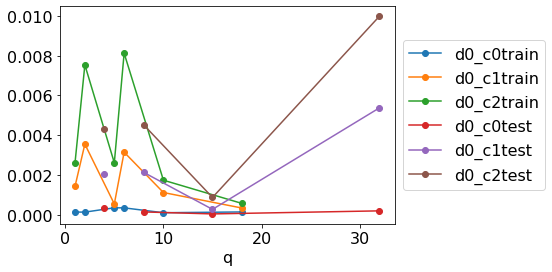

In [210]:
for col in cols:
    df_train.groupby(by='q').std()[col].plot(label=col+"train", marker='o', ls='-')
for col in cols:
    df_test.groupby(by='q').std()[col].plot(label=col+"test", marker='o', ls='-')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

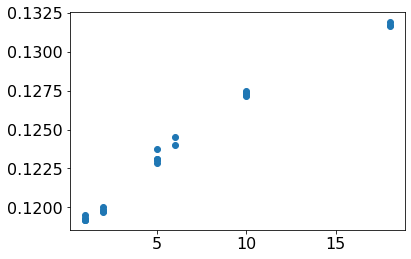

In [211]:
plt.figure()
plt.plot(df_train['q'], df_train[cols[0]], 'o')

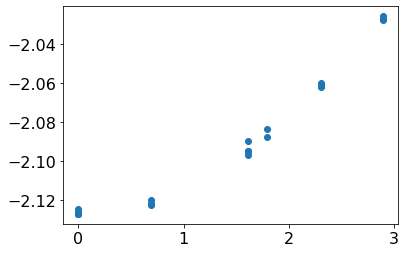

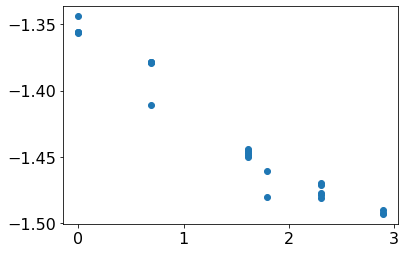

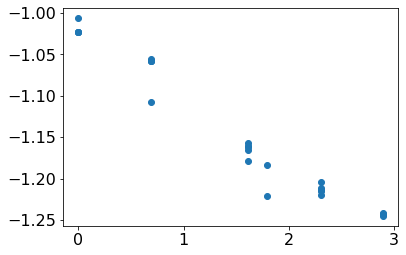

In [212]:
for col in cols:
    plt.figure()
    plt.plot(np.log(df_train['q']), np.log(df_train[col]), 'o')

In [213]:
from tinygp import kernels, GaussianProcess
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.linen.initializers import zeros
import optax

polynomial_noise_model = lambda a, b, c, x: a + b*x + c*x**2



class GPModule(nn.Module):
    @nn.compact
    def __call__(self, x_train, y_train, x_test):
        mean = self.param("mean", zeros, ())
        # log_jitter = self.param("log_jitter", zeros, ())
        log_jitter_a = self.param("log_jitter_a", zeros, ())
        log_jitter_b = self.param("log_jitter_b", zeros, ())
        log_jitter_c = self.param("log_jitter_c", zeros, ())
  
        log_sigma = self.param("log_sigma", zeros, ())
        log_rho = self.param("log_rho", zeros, ())
        # kernel1 = jnp.exp(2 * log_sigma) * kernels.ExpSquared(jnp.exp(log_rho))
        kernel1 = jnp.exp(2 * log_sigma) * kernels.Matern32(jnp.exp(log_rho))
        # kernel1 = jnp.exp(2 * log_sigma) * kernels.Matern52(jnp.exp(log_rho))

        # log_sigma2 = self.param("log_sigma2", zeros, ())
        # log_const = self.param("log_const", zeros, ())
        # kernel2 = kernels.DotProduct()*kernels.Constant(jnp.exp(log_const))
        # kernel = kernel1 + kernel2
        kernel = kernel1
        
        # diag = yerr**2 + jnp.exp(log_jitter)
        # diag = jnp.exp(log_jitter)
        diag = polynomial_noise_model(jnp.exp(log_jitter_a), jnp.exp(log_jitter_b), jnp.exp(log_jitter_c), x_train)
        gp = GaussianProcess(
            kernel, x_train, diag=diag, mean=mean
        )

        diag = polynomial_noise_model(jnp.exp(log_jitter_a), jnp.exp(log_jitter_b), jnp.exp(log_jitter_c), x_test)
        # log_prob, gp_cond = gp.condition(y_train, x_test, diag=diag)
        log_prob, gp_cond = gp.condition(y_train, x_test, diag=diag)
        return -log_prob, gp_cond.loc, gp_cond.variance

In [214]:
col = cols[0]
x_train = df_train['q'].to_numpy()
y_train = df_train[col].to_numpy()

x_test = df_test['q'].to_numpy()
y_test = df_test[col].to_numpy()


x_train = np.log(x_train)
y_train = np.log(y_train)
x_test = np.log(x_test)
y_test = np.log(y_test)

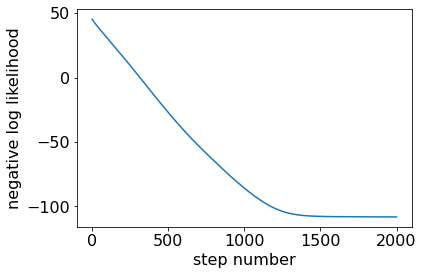

In [215]:

def loss(params):
    return model.apply(params, x_train, y_train, x_test)[0]


model = GPModule()
params = model.init(jax.random.PRNGKey(0), x_train, y_train, x_test)
tx = optax.sgd(learning_rate=3e-3)
# tx = optax.adam(learning_rate=3e-3)
opt_state = tx.init(params)
loss_grad_fn = jax.jit(jax.value_and_grad(loss))

losses = []
for i in range(2001):
    loss_val, grads = loss_grad_fn(params)
    losses.append(loss_val)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

plt.plot(losses)
plt.ylabel("negative log likelihood")
_ = plt.xlabel("step number")

In [216]:
params

FrozenDict({
    params: {
        log_jitter_a: Array(-13.632746, dtype=float32),
        log_jitter_b: Array(-14.018532, dtype=float32),
        log_jitter_c: Array(-15.008881, dtype=float32),
        log_rho: Array(1.8033226, dtype=float32),
        log_sigma: Array(-2.3429596, dtype=float32),
        mean: Array(-2.0405376, dtype=float32),
    },
})

In [217]:
params['params']

FrozenDict({
    log_jitter_a: Array(-13.632746, dtype=float32),
    log_jitter_b: Array(-14.018532, dtype=float32),
    log_jitter_c: Array(-15.008881, dtype=float32),
    log_rho: Array(1.8033226, dtype=float32),
    log_sigma: Array(-2.3429596, dtype=float32),
    mean: Array(-2.0405376, dtype=float32),
})

In [218]:
try:
    print(np.exp(params['params']['log_jitter']))
except:
    print(np.exp(params['params']['log_jitter_a']))
    print(np.exp(params['params']['log_jitter_b']))
    print(np.exp(params['params']['log_jitter_c']))

1.200532e-06
8.162609e-07
3.0319774e-07


In [219]:
x_fine = np.linspace(np.log(1), np.log(50), 100)
# x_fine = np.linspace(1,32, 100)

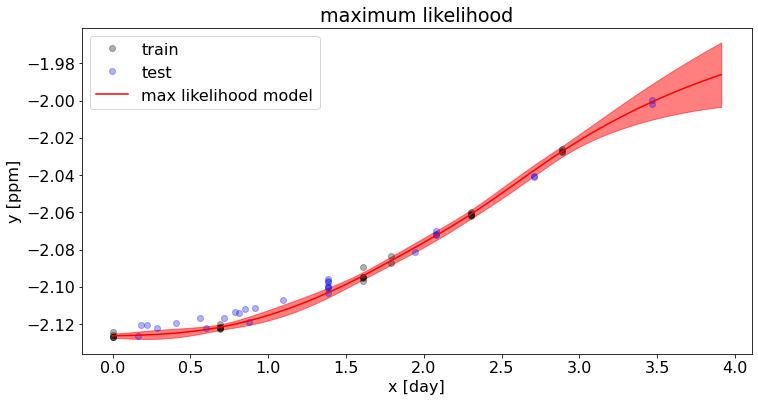

In [220]:
pred_mu = model.apply(params, x_train, y_train, x_fine)[1]
pred_var = model.apply(params, x_train, y_train, x_fine)[2]
pred_std = np.sqrt(pred_var)


plt.figure(figsize=(12,6))
plt.plot(x_train, y_train, "ok", lw=1.5, alpha=0.3, label="train")
plt.plot(x_test, y_test, "ob", lw=1.5, alpha=0.3, label="test")
# plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_fine, pred_mu, label="max likelihood model", c='r')
plt.fill_between(x_fine, y1=pred_mu-pred_std, y2=pred_mu+pred_std, color='r', alpha=0.5)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
# plt.xlim(0, 10)
# plt.ylim(-2.5, 2.5)
plt.legend()
_ = plt.title("maximum likelihood")

In [221]:
df_train[['q',col]].apply(np.log).groupby(by='q').std().apply(np.sqrt)

d0_c0
q                 
0.000000  0.033388
0.693147  0.032703
1.609438  0.052958
1.791759  0.052587
2.302585  0.027817
2.890372  0.032366

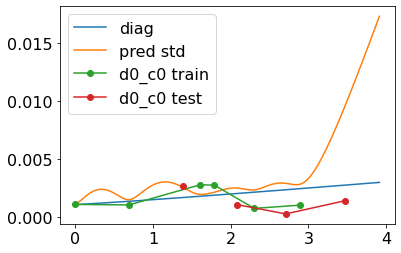

In [222]:
try:
    diag = polynomial_noise_model(jnp.exp(params['params']['log_jitter_a']), jnp.exp(params['params']['log_jitter_b']), jnp.exp(params['params']['log_jitter_c']), x_fine)
    plt.plot(x_fine, np.sqrt(diag), label='diag')
except:
    pass
plt.plot(x_fine, pred_std, label='pred std')

p_train = df_train[['q',col]].apply(np.log).groupby(by='q').std().reset_index()
plt.plot(p_train['q'], p_train[col], 'o-', label=col+" train")

p_test = df_test[['q',col]].apply(np.log).groupby(by='q').std().reset_index()
plt.plot(p_test['q'], p_test[col], 'o-', label=col+" test")

# .plot(label=col+"train", marker='o', ls='-', ax=plt.gca())
# df_test[['q',col]].apply(np.log).groupby(by='q').std().plot(label=col+"test", marker='o', ls='-', ax=plt.gca())
# df_train[['q',col]].groupby(by='q').std().plot(label=col, marker='o', ls='-', ax=plt.gca())
# df_test[['q',col]].groupby(by='q').std().plot(label=col, marker='o', ls='-', ax=plt.gca())
plt.legend()

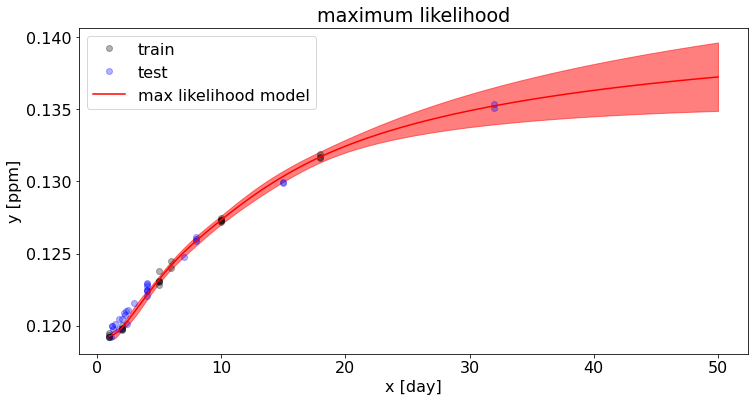

In [223]:



plt.figure(figsize=(12,6))
plt.plot(np.exp(x_train), np.exp(y_train), "ok", lw=1.5, alpha=0.3, label="train")
plt.plot(np.exp(x_test), np.exp(y_test), "ob", lw=1.5, alpha=0.3, label="test")
# plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(np.exp(x_fine), np.exp(pred_mu), label="max likelihood model", c='r')
plt.fill_between(np.exp(x_fine), y1=np.exp(pred_mu-pred_std), y2=np.exp(pred_mu+pred_std), color='r', alpha=0.5)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
# plt.xlim(0, 10)
# plt.ylim(-2.5, 2.5)
plt.legend()
_ = plt.title("maximum likelihood")

# Modularise the code

In [224]:
from tinygp import kernels, GaussianProcess
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.linen.initializers import zeros
import optax

polynomial_noise_model = lambda a, b, c, x: a + b*x + c*x**2

class GP_homosk_Module(nn.Module):
    """
    homoskedastic GP model i.e. standard model with a constant noise term
    """
    @nn.compact
    def __call__(self, x_train, y_train, x_test):
        mean = self.param("mean", zeros, ())
        log_jitter = self.param("log_jitter", zeros, ())
  
        log_sigma = self.param("log_sigma", zeros, ())
        log_rho = self.param("log_rho", zeros, ())
        kernel1 = jnp.exp(2 * log_sigma) * kernels.Matern32(jnp.exp(log_rho))
        kernel = kernel1
        
        # diag = yerr**2 + jnp.exp(log_jitter)
        diag = jnp.exp(log_jitter)
        gp = GaussianProcess(
            kernel, x_train, diag=diag, mean=mean
        )

        log_prob, gp_cond = gp.condition(y_train, x_test, diag=diag)
        return -log_prob, gp_cond.loc, gp_cond.variance

class GP_polynomial_noise_Module(nn.Module):
    """
    heteroskedastic GP model i.e. variable noise model, modelled using a quadtraic
    """
    @nn.compact
    def __call__(self, x_train, y_train, x_test):
        mean = self.param("mean", zeros, ())
        # log_jitter = self.param("log_jitter", zeros, ())
        log_jitter_a = self.param("log_jitter_a", zeros, ())
        log_jitter_b = self.param("log_jitter_b", zeros, ())
        log_jitter_c = self.param("log_jitter_c", zeros, ())
  
        log_sigma = self.param("log_sigma", zeros, ())
        log_rho = self.param("log_rho", zeros, ())
        kernel1 = jnp.exp(2 * log_sigma) * kernels.Matern32(jnp.exp(log_rho))
        kernel = kernel1
        
        diag = polynomial_noise_model(jnp.exp(log_jitter_a), jnp.exp(log_jitter_b), jnp.exp(log_jitter_c), x_train)
        gp = GaussianProcess(
            kernel, x_train, diag=diag, mean=mean
        )

        diag = polynomial_noise_model(jnp.exp(log_jitter_a), jnp.exp(log_jitter_b), jnp.exp(log_jitter_c), x_test)
        log_prob, gp_cond = gp.condition(y_train, x_test, diag=diag)
        return -log_prob, gp_cond.loc, gp_cond.variance

    

In [225]:
params

FrozenDict({
    params: {
        log_jitter_a: Array(-13.632746, dtype=float32),
        log_jitter_b: Array(-14.018532, dtype=float32),
        log_jitter_c: Array(-15.008881, dtype=float32),
        log_rho: Array(1.8033226, dtype=float32),
        log_sigma: Array(-2.3429596, dtype=float32),
        mean: Array(-2.0405376, dtype=float32),
    },
})

In [226]:
def loss_generic(model, x_train, y_train, x_test, params):
    return model.apply(params, x_train, y_train, x_test)[0]


In [227]:
def train_model(model, x_train, y_train, x_test):
    loss = functools.partial(loss_generic, model, x_train, y_train, x_test)
    params = model.init(jax.random.PRNGKey(0), x_train, y_train, x_test)
    tx = optax.sgd(learning_rate=3e-3)
    # tx = optax.adam(learning_rate=3e-3)
    opt_state = tx.init(params)
    loss_grad_fn = jax.jit(jax.value_and_grad(loss))

    losses = []
    for i in range(2001):
        loss_val, grads = loss_grad_fn(params)
        losses.append(loss_val)
        updates, opt_state = tx.update(grads, opt_state)
        params = optax.apply_updates(params, updates)


    plt.plot(losses)
    plt.ylabel("negative log likelihood")
    _ = plt.xlabel("step number")

    return model, params

In [228]:
model_homosk = GP_homosk_Module()

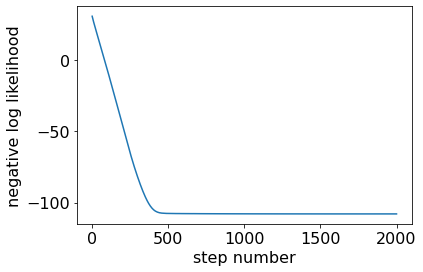

In [229]:
model_homosk, params_homosk = train_model(model_homosk, x_train, y_train, y_test)

In [230]:
params_homosk

FrozenDict({
    params: {
        log_jitter: Array(-12.804996, dtype=float32),
        log_rho: Array(1.9049685, dtype=float32),
        log_sigma: Array(-2.2319324, dtype=float32),
        mean: Array(-2.0346344, dtype=float32),
    },
})

# modularising the code without using Flax

In [231]:
import jax
import jax.numpy as jnp
from tinygp import kernels, GaussianProcess
import numpy as np


# jax.config.update("jax_enable_x64", True)

def build_gp(theta, X):
    amp = jnp.exp(2 * theta["log_amp"])
    scale = jnp.exp(theta["log_scale"])
    diag = jnp.exp(theta["log_diag"])
    kernel = amp * kernels.Matern32(scale=scale)
    return GaussianProcess(
        kernel, X, diag=diag, mean=theta["mean"]
    )


def build_neg_log_likelihood(build_gp_fn):
    def neg_log_likelihood(theta, X, y):
        gp = build_gp_fn(theta, X)
        return -gp.log_probability(y)
    return neg_log_likelihood


theta_init = {
    "log_diag": np.log(1.0),
    "log_scale": np.log(1.0),
    "log_amp": np.log(1.0),
    "mean": np.float64(0.0),
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
neg_log_likelihood = build_neg_log_likelihood(build_gp)



In [232]:
# obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

# print(f"Initial negative log likelihood: {obj(theta_init, x_train, y_train)[0]}")

# print(
#     f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, x_train, y_train)[1]}"
# )

In [233]:
import jaxopt

def fit(X, y, loss, init):
    solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
    soln = solver.run(init, X=X, y=y)
    # print(f"Final negative log likelihood: {soln.state.fun_val}")
    return soln

In [234]:
soln = fit(X=x_train, y=y_train, loss=neg_log_likelihood, init=theta_init)

In [235]:
soln.params

{'log_amp': Array(-0.3256562, dtype=float32),
 'log_diag': Array(-12.828129, dtype=float32),
 'log_scale': Array(3.392925, dtype=float32),
 'mean': Array(-1.7898691, dtype=float32)}

In [236]:
params['params']

FrozenDict({
    log_jitter_a: Array(-13.632746, dtype=float32),
    log_jitter_b: Array(-14.018532, dtype=float32),
    log_jitter_c: Array(-15.008881, dtype=float32),
    log_rho: Array(1.8033226, dtype=float32),
    log_sigma: Array(-2.3429596, dtype=float32),
    mean: Array(-2.0405376, dtype=float32),
})

In [237]:
def build_predict_func(build_gp_fn, theta, X_train, y_train):
    """
    X: inference locations
    theta: gp parameters
    """
    gp = build_gp_fn(theta, X_train)
    def predict(X):
        """returns loc and std"""
        cond_gp = gp.condition(y_train, X, diag=np.exp(theta['log_diag'])).gp
        return cond_gp.loc, np.sqrt(cond_gp.variance)
    return predict

In [238]:
x_fine = np.linspace(np.log(1), np.log(50), 100)
theta = soln.params
predict = build_predict_func(build_gp, theta, x_train, y_train)
# mu, var = cond_gp(x_fine).loc, cond_gp(x_fine).variance
mu, std = predict(x_fine)

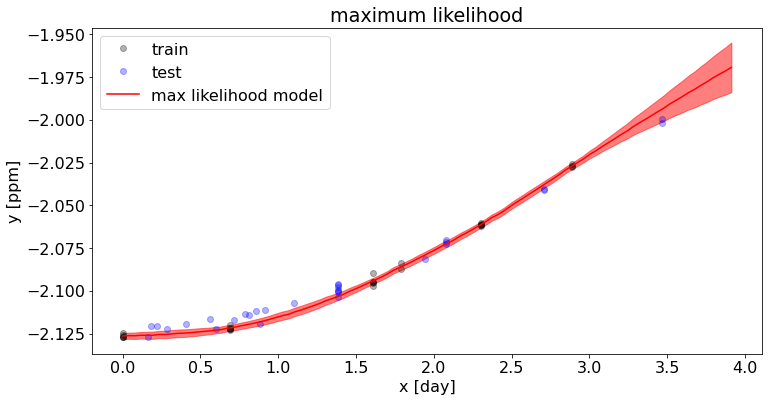

In [239]:
plt.figure(figsize=(12,6))
plt.plot(x_train, y_train, "ok", lw=1.5, alpha=0.3, label="train")
plt.plot(x_test, y_test, "ob", lw=1.5, alpha=0.3, label="test")
# plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_fine, mu, label="max likelihood model", c='r')
plt.fill_between(x_fine, y1=mu-std, y2=mu+std, color='r', alpha=0.5)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
# plt.xlim(0, 10)
# plt.ylim(-2.5, 2.5)
plt.legend()
_ = plt.title("maximum likelihood")

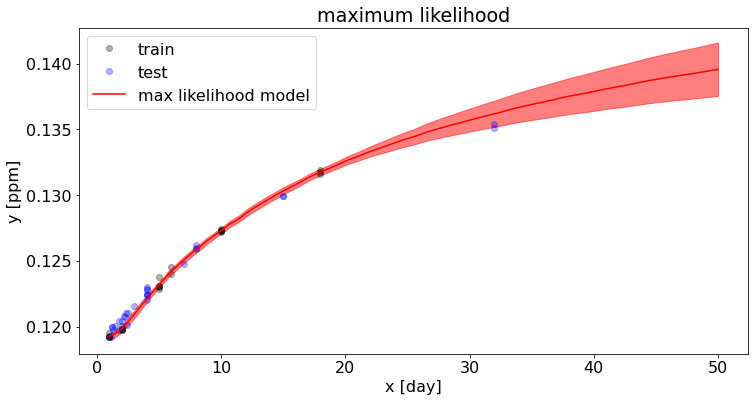

In [240]:
plt.figure(figsize=(12,6))
plt.plot(np.exp(x_train), np.exp(y_train), "ok", lw=1.5, alpha=0.3, label="train")
plt.plot(np.exp(x_test), np.exp(y_test), "ob", lw=1.5, alpha=0.3, label="test")
# plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(np.exp(x_fine), np.exp(mu), label="max likelihood model", c='r')
plt.fill_between(np.exp(x_fine), y1=np.exp(mu-std), y2=np.exp(mu+std), color='r', alpha=0.5)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
# plt.xlim(0, 10)
# plt.ylim(-2.5, 2.5)
plt.legend()
_ = plt.title("maximum likelihood")

# using module

In [241]:
import gpr_utils

In [242]:


# # define gp and loss func
# neg_log_likelihood = gpr_utils.build_neg_log_likelihood(gpr_utils.build_gp)
# # fit gp
# soln = gpr_utils.fit(X=x_train, y=y_train, loss_fun=neg_log_likelihood, init=theta_init)
# # get predict function i.e. condition learned gp
# predict = gpr_utils.build_predict_func(gpr_utils.build_gp, soln.params, x_train, y_train)

# x_fine = np.linspace(np.log(1), np.log(50), 100)
# mu, std = predict(x_fine)

In [243]:
theta_init = {
    "log_diag": np.log(1.0),
    "log_scale": np.log(1.0),
    "log_amp": np.log(1.0),
    "mean": np.float64(0.0),
}


gp_model = gpr_utils.GPRModel(build_gp_fn=gpr_utils.build_gp, theta_init=theta_init)
gp_model.fit(x_train, y_train)
mu, std = gp_model.predict(x_fine)

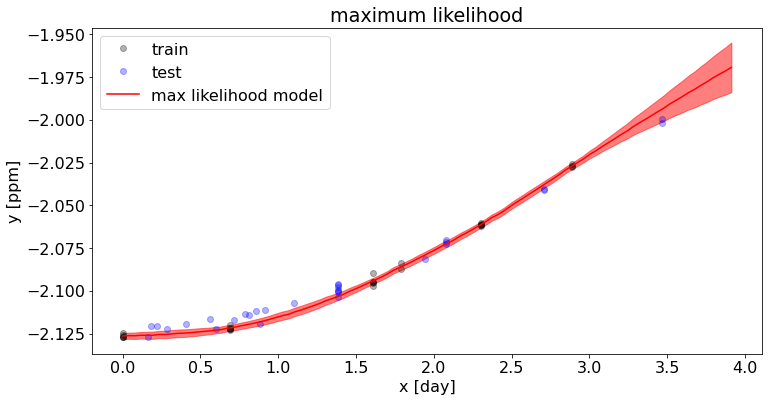

In [244]:
plt.figure(figsize=(12,6))
plt.plot(x_train, y_train, "ok", lw=1.5, alpha=0.3, label="train")
plt.plot(x_test, y_test, "ob", lw=1.5, alpha=0.3, label="test")
# plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_fine, mu, label="max likelihood model", c='r')
plt.fill_between(x_fine, y1=mu-std, y2=mu+std, color='r', alpha=0.5)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
# plt.xlim(0, 10)
# plt.ylim(-2.5, 2.5)
plt.legend()
_ = plt.title("maximum likelihood")

In [251]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel
# sk_kernel = ConstantKernel() * Matern() + ConstantKernel() + WhiteKernel()
sk_kernel = ConstantKernel() * Matern() + WhiteKernel()
sk_gpr = GaussianProcessRegressor(kernel=sk_kernel, random_state=0, normalize_y=True, n_restarts_optimizer=100).fit(x_train[:,np.newaxis], y_train)


sk_mu, sk_std = sk_gpr.predict(x_fine[:,np.newaxis], return_std=True)

In [252]:
sk_gpr.kernel_

3.23**2 * Matern(length_scale=6.59, nu=1.5) + WhiteKernel(noise_level=0.00247)

In [253]:
print(np.exp(gp_model.theta['log_amp'])**2)
print(gp_model.theta['mean'])
print(np.exp(gp_model.theta['log_diag']))
print(np.exp(gp_model.theta['log_scale']))

0.52136112490372
-1.7898691
2.6841974e-06
29.752853


In [254]:
np.sqrt(1e-5-2.6841974e-06)

0.002704774038621341

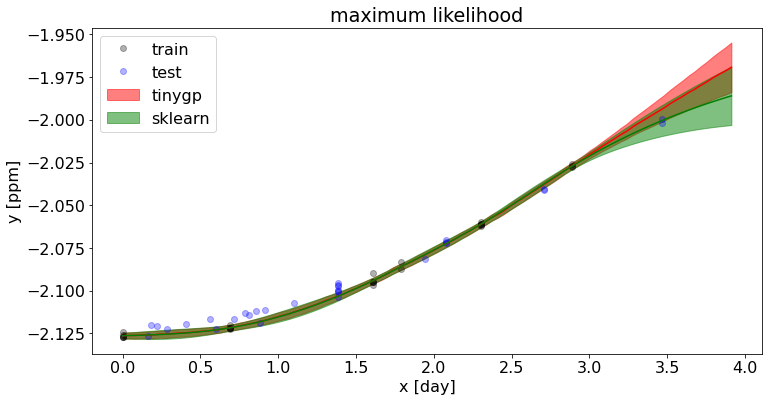

In [255]:
plt.figure(figsize=(12,6))
plt.plot(x_train, y_train, "ok", lw=1.5, alpha=0.3, label="train")
plt.plot(x_test, y_test, "ob", lw=1.5, alpha=0.3, label="test")
# plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_fine, mu, c='r')
plt.fill_between(x_fine, y1=mu-std, y2=mu+std, color='r', alpha=0.5, label='tinygp')
plt.plot(x_fine, sk_mu, c='g')
plt.fill_between(x_fine, y1=sk_mu-sk_std, y2=sk_mu+sk_std, color='g', alpha=0.5, label='sklearn')
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
# plt.xlim(0, 10)
# plt.ylim(-2.5, 2.5)
plt.legend()
_ = plt.title("maximum likelihood")

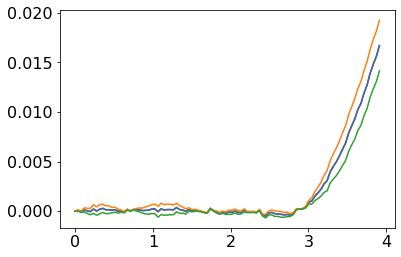

In [256]:
plt.plot(x_fine, mu-sk_mu, c='r')

lower_1 = mu-std
lower_2 = sk_mu-sk_std

upper_1 = mu+std
upper_2 = sk_mu+sk_std

plt.plot(x_fine, mu-sk_mu)
plt.plot(x_fine, lower_1-lower_2)
plt.plot(x_fine, upper_1-upper_2)